# Lab 4

In [70]:
import numpy as np
from matplotlib import pyplot as plt
import astropy
import scipy
import astropy.constants as con
import astropy.units as u
import scipy.special
import scipy.signal
import matplotlib.cm as cm
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from matplotlib.patches import Rectangle
from astropy.io import fits
import os
import scipy.interpolate
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata

In [71]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.linewidth'] = 1

In [130]:
def calc_avg_power_fft(data):
    fft = np.fft.fft(data)
    pow_data = np.abs(fft)**2
    avg_data = np.mean(pow_data, axis=1)
    return np.fft.fftshift(avg_data)

def calc_avg(data):
    return np.mean(data, axis=1)

def calc_median_power_fft(data):
    fft = np.fft.fft(data)
    pow_data = np.abs(fft)**2
    avg_data = np.median(pow_data, axis=1)
    return np.fft.fftshift(avg_data)

def calc_freq(samples, frequency):
    return np.fft.fftshift(np.fft.fftfreq(samples, d=1/frequency))

def calc_gain(main_data, on_data, off_data):
    
    """
    A simple function to compute the gain for a given coordinate.
    """    
    
    T_NOISE = 90 # Kelvin
    G = (T_NOISE/(np.sum(on_data-off_data))) * np.sum(off_data) #calc Gain
    
    return G

def calc_velocities(main_file=None):
    
    """
    A simple function to calculate the velocities
    """
    
    FREQ_RES = 8192 
    LO = 1270 #Mhz
    RF = 1420.4058 #Mhz
    c = 3e5 #km/s
    freqs = np.linspace(144,156,FREQ_RES) 
    velocities = (((freqs+LO)-RF)/RF)*c #doppler velocities
    
    if main_file is None:
        correction = 0
        
    return (velocities)

def T_0(main_data, on_data, off_data):
#     T_NOISE = 90 # Kelvin
    
#     G = calc_gain(main_data,on_data,off_data)
#     max_value = np.max((main_data/off_data))
#     max_index = np.argmax((main_data/off_data))
#     T = G * (max_value - 1)
#     return T

    T_NOISE = 90 # Kelvin
    
    G = calc_gain(main_data,on_data,off_data)
    max_value = np.max((main_data/off_data))
    max_index = np.argmax((main_data/off_data))
    velocities = calc_velocities()
    
    
    fitting_indeces = np.where((velocities > -70) & (velocities < 50)) # we zoom in to ignore the ripples
    G = calc_gain(main_data,on_data,off_data)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
    x_data_fit = velocities
    x_data_fit = x_data_fit[fitting_indeces]
    max_value = np.max(y_data_fit[np.where(x_data_fit<40)])
    max_index = np.argmax(y_data_fit[np.where(x_data_fit<40)])
    T = max_value

    return T

def V_0(averaged_data, averaged_noise, averaged_no_noise):
    ind_1=np.where(velocities>-50)[0][0]# Get indices for median
    ind_2=np.where(velocities<50)[0][-1]# Get indices for median
    G=(90/(np.sum(averaged_noise-averaged_no_noise)))*np.sum(averaged_no_noise)# Get Gain
    med=np.median((averaged_data[ind_1:ind_2]/averaged_no_noise[ind_1:ind_2]))# Get median
    y_data_fit = (averaged_data/averaged_no_noise)*G-G*med
    y_data_fit = y_data_fit[ind_1:ind_2]
    x_data_fit = velocities + correction
    x_data_fit = x_data_fit[ind_1:ind_2]
    plt.plot(x_data_fit,y_data_fit)
    fit_params_on1 = ugradio.gauss.gaussfit(x_data_fit, y_data_fit, amp=50, avg=20, sig=25)#get fit
    chisq_r_s = []
    for i in range(1):
        ys = (averaged_data/averaged_no_noise)*G-med*G
        xs = velocities + correction
        chisq_r_s.append(np.sum(np.abs(y_data_fit - ugradio.gauss.gaussval(x_data_fit, **fit_params_on1))**2) / (y_data_fit.size - 3) / np.std(y_data_fit[:190])**2)
    return (fit_params_on1['avg'][0])

In [58]:
# (l = 105◦ to 160◦),(b = 15◦ to 50◦)

dg = u"\N{DEGREE SIGN}"

def plot_FOV(ax, color, label):
    
    FOV = (2 * (np.pi/180))/ 2 #set by the telescope. We have a 2 degree field of view
    n = 10
    xarr = np.arange(105, 160, 2)
    yarr = np.arange(15, 50, 2)
    for i in range(len(xarr)):
        for j in range(len(yarr)):
            x, y = xarr[i], yarr[j]
            gal = SkyCoord(x*u.degree, y*u.degree, frame='galactic')
            ra_dec = gal.transform_to('fk5')
#             print(ra_dec)
        #     gal = eq.galactic
        #     print(gal.l)

        #     ax.scatter(gal.l,gal.b,alpha=0.5,marker="s",s=200,color=color, label=label)
            ax.add_patch(Rectangle((ra_dec.ra.wrap_at('180d').radian - FOV, ra_dec.dec.radian - FOV),FOV*2 , FOV*2,
                         edgecolor = color,
                         facecolor = color,
                         alpha=0.5,
                         fill=True,
                         lw=3))
    
# plot_FOV(ax, RA_z, DEC_z, color="blue", label="Calibration")

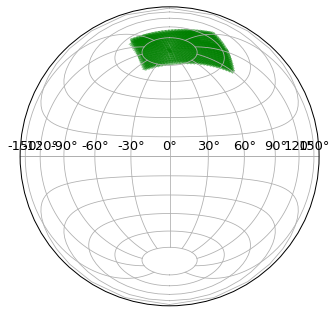

In [59]:
f = plt.figure(figsize=(9,5.5))

ax = plt.subplot(111, projection='lambert')
ax.grid(True)

plot_FOV(ax, color="green", label="Target")

In [60]:
import matplotlib
matplotlib.projections.get_projection_names()

['aitoff', 'hammer', 'lambert', 'mollweide', 'polar', 'rectilinear']

In [61]:
# fits_image_filename = fits.util.get_testdata_filepath('data/off.fits')

off_data = fits.open('data/off.fits')
on_data = fits.open('data/on.fits')

In [63]:
data_off = np.zeros((8192, len(off_data)-1))
data_on = np.zeros((8192, len(off_data)-1))
# print(off_data.shape)
for i in range(1, len(off_data)):
    data_off[:,i-1] = off_data[i].data['auto0_real']
    data_on[:,i-1] = on_data[i].data['auto0_real']

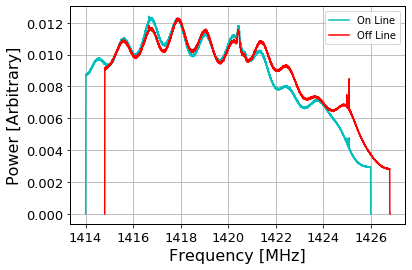

In [93]:
avg_fft_off = calc_avg_power_fft(data_off)
avg_fft_on = calc_avg_power_fft(data_on)
# freq = calc_freq(samples=8192, frequency=150)
freq = np.linspace(144, 156, 8192)
# plt.plot(freq+1270, avg_fft_off, label='Off')
# plt.plot(freq+1270.8, avg_fft_on, label='On')
avg_data_on = calc_avg(data_on)
avg_data_off = calc_avg(data_off)
plt.plot(freq+1270, avg_data_on, label='On Line', color='c')
plt.plot(freq+1270.8, avg_data_off, label='Off Line', color='r')
# plt.ylim(0.0095, 0.012)
# plt.xlim(1419, 1421)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [Arbitrary]')
plt.legend()
# plt.xlim(1420,1421)

## Process coordinate data from Darby's folder

In [190]:
# SCRIPT TO COMPRESS TO NUMPY ARRAYS
# import os
# from astropy.io import fits

# for filename in os.listdir(os.getcwd()):
#     if filename == ".ipynb_checkpoints":
#         continue
#     split_name = filename.split("_")
#     if split_name[0] != 'celestial':
#         continue

#     if split_name[2] == 'off':
#         prefix = 'off' # off
#     elif splits_name[2] == 'on':
#         prefix = 'on' # on
#     else:
#         prefix = 'main' # main

#     l, b = split_name[-1].split(" , ")
#     b = b.split('.fits')[0]
#     num_l, num_b = float(l), float(b) # convert strings to floats

#     fits_data = fits.open(filename)
#     data_arr = np.zeros((8192, len(fits_data)-1))

#     for i in range(1, len(fits_data)):
#         data_arr[:,i-1] = fits_data[i].data['auto0_real']
    
#     new_filename = os.getcwd() +'/celestial_data/' + prefix + '_' + l + '_' + b + '_.fits'
#     np.save(data_arr, new_filename)
    
        

In [189]:
# currently not used, but maybe this would be neater?
class Observation:
    def __init__(self, main, on, off, l, b, ra, dec, jd):
        self.main = main
        self.on = on
        self.off = off
        self.coord = (l, b)
        self.ra = ra
        self.dec = dec
        self.jd = jd
        self.l = l
        self.b = b
    

## CODE TO LOAD .npy TO DICTIONARY AND EXTRACT INFO FROM FILENAMES

In [191]:
# CODE TO LOAD SPECTRA NUMPY FILES IN A DICT

data_dict = {} # dict where key is coordinate (l, b)) and value is [main, noise_on, noise_off, [ra, dec, jd]]
                # where main, noise_on, noise_off are all numpy arrays of the spectra
for filename in os.listdir(os.getcwd() + '/celestial_data'):
    if filename == ".ipynb_checkpoints" or filename == '.DS_Store':
        continue
    split_name = filename.split("_")

    if split_name[0] == 'off':
        fits_type = 2 # off
    elif split_name[0] == 'on':
        fits_type = 1 # on
    else:
        fits_type = 0 # main

    #l, b, ra, dec, jd
    _, l, b, ra, dec, jd, _ = split_name
    l, b, ra, dec, jd = float(l), float(b), float(ra), float(dec), float(jd) # convert strings to floats

    curr_data = np.load('celestial_data/' + filename) # load the spectra from file
    curr_data = calc_avg(curr_data) # keep the avg in the dict
    
    if not data_dict.get((l, b)):
        data_dict[(l, b)] = [[], [], [], ra, dec, jd]      
    data_dict[(l, b)][fits_type] = curr_data
        

In [194]:
# RUN THIS CELL TO LOOP THROUGH ALL SPECTRA 
# SAVES ls, bs, ras, decs, jds, specs (main), and Ts which are ordered in the same order

ls = []
bs = []
ras, decs, jds = [], [], []
specs = []
Ts = []

for coord in data_dict.keys():
    l, b = coord
    main, noise_on, noise_off, ra, dec, jd = data_dict.get(coord)
    
    if len(main) == 0 or len(noise_on) == 0 or len(noise_off) == 0:
        print(coord)
        continue
    temperature = T_0(main, noise_on, noise_off)
    
    ls.append(l)
    bs.append(b)
    specs.append(main)
    Ts.append(temperature)
    ras.append(ra)
    decs.append(dec)
    jds.append(jd)

#bayern13 18rway
print(len(ras), len(decs))

(158.8716594064493, 27.0)
400 400


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


(0.006, 0.009800793578848244)

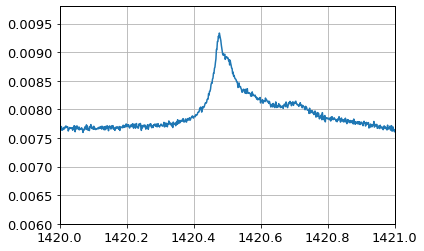

In [195]:
freq = np.linspace(144, 156, 8192)
plt.plot(freq+1270, main)
plt.xlim(1420,1421)
plt.ylim(0.006,)

In [206]:
l_min, l_max = 105, 159.996
b_min, b_max = 15, 49
resolution = 500
lrange, brange = np.linspace(l_min, l_max, resolution), np.linspace(b_min, b_max, resolution)
print(lrange.shape, brange.shape)
Lgrid, Bgrid = np.meshgrid(lrange, brange)
print(len(ls), len(bs), len(Ts))
print(min(ls), max(ls), min(bs), max(bs))
print(lrange.max())

(500,) (500,)
400 400 400
105.0 159.9962754217069 15.0 49.0
159.996


In [207]:
interpolated_temps = scipy.interpolate.interp2d(ls, bs, Ts, kind='linear')
print(interpolated_temps)

In [208]:
temps = interpolated_temps(lrange, brange)
print(temps)

[[131.23352593 127.75849698 124.28346803 ...  23.2411461   21.20764189
   19.17413769]
 [119.02766185 115.87584094 112.72402004 ...  21.07951653  19.23514597
   17.39077542]
 [106.82179777 103.9931849  101.16457204 ...  18.91788696  17.26265005
   15.60741315]
 ...
 [ 16.36221263  15.57232051  14.78242839 ... -15.76384541 -17.42436493
  -19.08488446]
 [ 16.39697128  15.61929862  14.84162595 ...  -1.43542173  -2.29050228
   -3.14558282]
 [ 16.43172993  15.66627672  14.9008235  ...  12.89300194  12.84336038
   12.79371881]]


Text(0, 0.5, 'b [$^o$]')

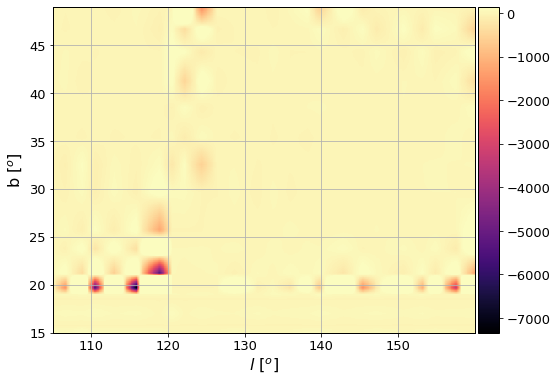

In [209]:
extent=[l_min, l_max, b_min, b_max]
f, ax = plt.subplots(1,1, figsize=(8,6))
im = ax.imshow(temps, origin="lower", extent=extent, cmap="magma", aspect="auto", vmax = 150)
divider1 = axgrid.make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size='5%', pad=0.05)
plt.colorbar(im, cax=cax1)
ax.set_xlabel('$l$ [$^o$]')
ax.set_ylabel('b [$^o$]')
# plt.imshow(temps, cmap='magma', vmax=100)

In [210]:
np.min(temps), np.max(temps)

(-7338.479250786662, 46850.839676121985)

In [211]:
np.min(Ts), np.max(Ts)

(2.818504830732735, 134.05147548910708)

Text(0.5, 1.0, 'Max Temperatures [K]')

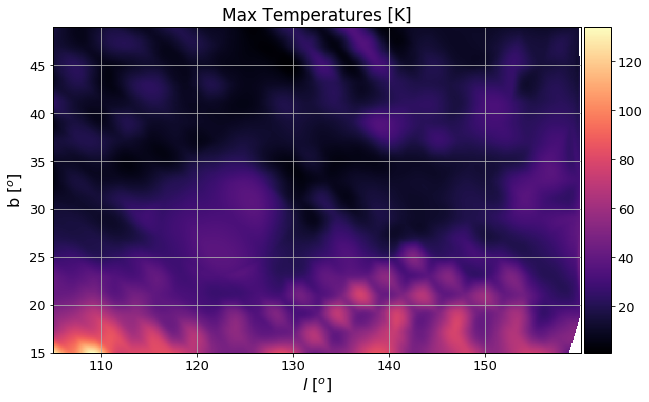

In [212]:
points = []
for i in range(len(ls)):
    points.append([ls[i],bs[i]])
grid_x, grid_y = np.mgrid[l_min:l_max:1, b_min:b_max:1]

# grid_temps = griddata(points, Ts, (grid_x, grid_y), method='cubic')
grid_temps = griddata(points, Ts, (Lgrid, Bgrid), method='cubic')

extent=[l_min, l_max, b_min, b_max]
f, ax = plt.subplots(1,1, figsize=(10,6))
im = ax.imshow(grid_temps, origin="lower", extent=extent, cmap="magma", aspect="auto")
divider1 = axgrid.make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size='5%', pad=0.05)
plt.colorbar(im, cax=cax1)
ax.set_xlabel('$l$ [$^o$]')
ax.set_ylabel('b [$^o$]')
ax.set_title('Max Temperatures [K]')

In [204]:
print(grid_temps.shape)

(5000, 5000)


In [205]:
print(grid_x)

[[105. 105. 105. ... 105. 105. 105.]
 [106. 106. 106. ... 106. 106. 106.]
 [107. 107. 107. ... 107. 107. 107.]
 ...
 [157. 157. 157. ... 157. 157. 157.]
 [158. 158. 158. ... 158. 158. 158.]
 [159. 159. 159. ... 159. 159. 159.]]
